In [1]:
import seaborn as sbn
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import pysam
import numpy as np

# Define functions

In [2]:
def parseDirectory(path):
    """Looks for sequencing files in input directory
    and opens them."""
    files = os.listdir(path)
    filesFilt = [x for x in files if "bam" in x]
    if len(filesFilt) == 0:
        filesFilt = [x for x in files if "sam" in x]
        if len(filesFilt) == 0:
            raise ValueError("No suitable file fount in the hicup directory!")
    filePaths = {i[0:6]: os.path.join(path, i) for i in filesFilt}
    return filePaths


def countMutations(alignment, mappingq=40, readqual=27, posQual=30, norm=True, reads=100000):
    MutDict = {"AC": 0.0, "AG": 0.0, "AT": 0.0, "CA": 0.0, "CG": 0.0,
               "CT": 0.0, "GA": 0.0, "GC": 0.0, "GT": 0.0, "TA": 0.0, "TC": 0.0, "TG": 0.0}
    BaseNumb = {"A": 0.0, "C": 0.0, "T": 0.0, "G": 0.0}
    for index, readInst in enumerate(alignment):
        if index % 10000 == 0:
            print("%s reads processed" % (index))
        if index > reads:
            break
        if readInst.mapping_quality < mappingq:
            continue
        if np.mean(readInst.query_qualities) < readqual:
            continue
        mutationCount, baseCount = getMutationlist(readInst, qual=posQual)
        for pointMut in MutDict.keys():
            MutDict[pointMut] += mutationCount.count(pointMut)
        for base in BaseNumb.keys():
            BaseNumb[base] += baseCount.get(base, 0)
    if norm:
        for pointMut in MutDict.keys():
            base = pointMut[0]
            MutDict[pointMut] = MutDict[pointMut]/BaseNumb[base]
    return MutDict


def getMutationlist(alignedSegment, qual=30):
    """Uses methods of pysam.AlignedSegment to get all pointmutations.
    Stores them as strings in self.MutationList.
    (e.g. AG corresponds to A mutated to G)"""
    pairs = alignedSegment.get_aligned_pairs(matches_only=False, with_seq=True)
    ref = np.array(
        [x[2].upper() if x[2] is not None else None for x in pairs])
    read = [x[0] for x in pairs]
    query = alignedSegment.query_sequence
    readBase = np.array(
        [query[x] if x is not None else None for x in read])
    readQuality = np.array(
        [alignedSegment.query_qualities[x] if x is not None else None for x in read])
    ind = ref == readBase
    final = []
    count = []
    for x, check in enumerate(ind):
        if not check and ((ref[x] is not None) and (readBase[x] is not None)):
            if readQuality[x] >= qual:
                final.append(ref[x] + readBase[x])
                count.append(ref[x])
        if ((ref[x] is not None) and (readBase[x] is not None)):
            if readQuality[x] >= qual:
                count.append(ref[x])
    return (final, Counter(count))


def mapBarcodes(filePaths, barcodefile, sep=","):
    """Takes in a comma seperated file containing Name and Sequence columns
    denoting a sample name under Name and the barcode sequence
    under Sequence. Will discard barcodes that are not in the barcodeFile.
    """
    output = {}
    barcodes = pd.read_csv(barcodefile, sep=sep)
    mapping = barcodes[["Name", "Sequence"]]
    for barcode in set(mapping["Sequence"]):
        newkey = mapping.loc[mapping.Sequence == barcode, "Name"]\
            .values[0]
        output[newkey] = filePaths[barcode]
    return output


def normalizeToControl(mutationDict, controlBar):
    """Sets the mutationrates stored in mutationDict as fold
    control.
    The control sample is defined through the controlBar parameter."""
    normDict = {}
    for barcode in mutationDict.keys():
        normDict[barcode] = {}
        for mut in set(mutationDict[barcode].keys()):
            if mutationDict[controlBar][mut] == 0:
                normDict[barcode][mut] = 0
            else:
                normDict[barcode][mut] = mutationDict[barcode][mut] / \
                    mutationDict[controlBar][mut]
    return normDict


def AnnotateMut(x):
    if x["mut"] in ["TC", "AG"]:
        return "4sT"
    return "Background"


# Analyze treated samples

In [3]:
# set Directory
os.chdir("/groups/gerlich/experiments/Experiments_004500/"
         "004594/Sequencing_data/")

# parse directory

files = parseDirectory("./")

# map barcodes

mapped = mapBarcodes(
    files, "/groups/gerlich/experiments/Experiments_004500/004574/Sample_mapping_exp4574.csv")

# open files and count mutations

mutationStats = {}

for barcode, fileP in mapped.items():
    mutationStats[barcode] = {}
    with pysam.AlignmentFile(fileP, "rb") as samfile:
        mutationStats[barcode] = countMutations(samfile, reads=50000, mappingq=38,
                                                readqual=30, posQual=30)

# normalize to control

normDict = normalizeToControl(mutationStats, controlBar="Control old NH4Cl")
HiCNormExp4574 = pd.melt(pd.DataFrame(
    normDict).transpose().reset_index(), id_vars="index")
HiCNormExp4574.columns = ["condition", "mut", "value"]

HiCNormExp4574.loc[:, "Mutationtype"] = HiCNormExp4574.apply(AnnotateMut,
                                                             axis=1)
HiCNormExp4574 = HiCNormExp4574.loc[HiCNormExp4574.condition
                                                  .isin(["4sT new NH4Cl 1",
                                                         "4sT new NH4Cl 2",
                                                         "4sT new NH4Cl 3"]), :]
HiCNormExp4574.condition = "OsO4 modified"

0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
40000 reads processed
50000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
40000 reads processed
50000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
40000 reads processed
50000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
40000 reads processed
50000 reads processed


# Analyze untreated samples

In [4]:
# define directory
seqDir = ("/groups/gerlich/experiments/Experiments_004500/004561/"
          "Sequencing_data/000000000-D_demultiplexed/hg19_SNPs/")
sampleMapDir = ("/groups/gerlich/experiments/Experiments_004500/004557/")


# parse directory

filesUntreated = parseDirectory("./")

# map barcodes

mappedUntreated = mapBarcodes(filesUntreated, os.path.join(
    sampleMapDir, "Sample_mapping_exp4557.csv"))

# open files and count mutations

mutationStatsUntreated = {}

for barcode, fileP in mappedUntreated.items():
    mutationStatsUntreated[barcode] = {}
    with pysam.AlignmentFile(fileP, "rb") as samfile:
        mutationStatsUntreated[barcode] = countMutations(samfile, reads=50000, mappingq=38,
                                                         readqual=30, posQual=30)

# normalize to control

normDictUntreated = normalizeToControl(
    mutationStatsUntreated, controlBar="Control 1 OsO4")
HiCNormExp4557 = pd.melt(pd.DataFrame(
    normDictUntreated).transpose().reset_index(), id_vars="index")
HiCNormExp4557.columns = ["condition", "mut", "value"]

HiCNormExp4557.loc[:, "Mutationtype"] = HiCNormExp4557.apply(AnnotateMut,
                                                             axis=1)
HiCNormExp4557 = HiCNormExp4557.loc[HiCNormExp4557.condition
                                                  .isin(["4sT 1 unmod",
                                                         "4sT 2 unmod",
                                                         "4sT 3 unmod"]), :]
HiCNormExp4557.condition = "Unmodified"

0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
40000 reads processed
50000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
40000 reads processed
50000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed


# Put both conditions into one dataframe and precalculate summar statistics for plotting

In [5]:
plotFrame = pd.concat((HiCNormExp4557, HiCNormExp4574), axis=0)

colors = ["black", "white"]


# calculate heights
heights = plotFrame.groupby(["mut", "condition"]).mean()
indexFrame = heights.index.to_frame()
indexFrame.loc[:, "value"] = heights["value"]
indexFrame.index = range(len(heights))
unmod = indexFrame.loc[indexFrame.condition == "Unmodified", :]
mod = indexFrame.loc[indexFrame.condition == "OsO4 modified", :]


# calculate error
stde = plotFrame.groupby(["mut", "condition"]).agg(
    lambda x: np.std(x)/np.sqrt(len(x)))
# order by condition
indError = stde.index.to_frame()
indError.loc[:, "value"] = stde["value"]
indError.index = range(len(stde))
unmodE = indError.loc[indError.condition == "Unmodified", :]
modE = indError.loc[indError.condition == "OsO4 modified", :]

errorUmod = [np.zeros(len(unmodE)), unmodE["value"].values]
errorMod = [np.zeros(len(modE)), modE["value"].values]

error_kw = {'capsize': 3, 'capthick': 2, 'ecolor': 'black'}

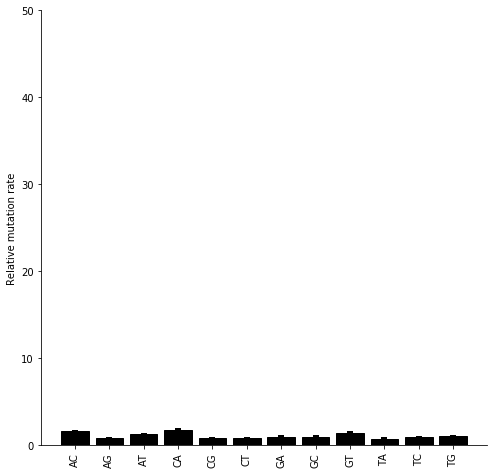

In [9]:
# unmodified samples
f, ax = plt.subplots()
ax.bar(range(0, len(unmod)), unmod["value"].values, yerr=errorUmod,
       error_kw=error_kw, edgecolor="black", color="black")
ax.set_ylim(0, 50)
sbn.despine()
ax.set_ylabel("Relative mutation rate")
ax.set_xlabel("")
plt.xticks([i for i in range(0, len(unmod))],
           unmod["mut"].values, rotation=90)
f.set_size_inches(8, 8)
plt.show()

# Plot modified samples

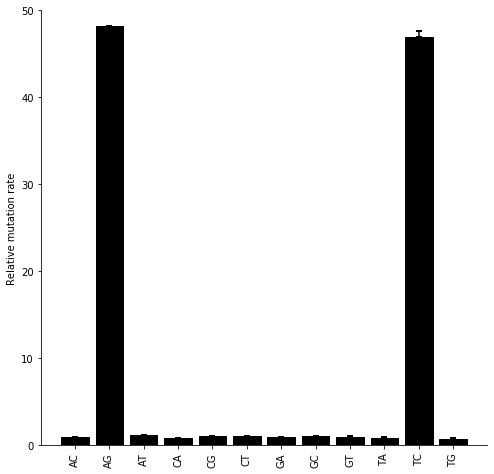

In [10]:
f, ax = plt.subplots()
ax.bar(range(0, len(mod)), mod["value"].values, yerr=errorMod,
       error_kw=error_kw, edgecolor="black", color="black")
ax.set_ylim(0, 50)
sbn.despine()
ax.set_ylabel("Relative mutation rate")
ax.set_xlabel("")
plt.xticks([i for i in range(0, len(mod))],
           mod["mut"].values, rotation=90)
f.set_size_inches(8, 8)
plt.show()

# Plot unmodified samples with individual datapoints overlaid

## Set plotting parameters

In [14]:
import matplotlib
matplotlib.rcParams.update({"pdf.fonttype": 42})

In [53]:
unmod = plotFrame.loc[plotFrame["condition"] == "Unmodified", :]


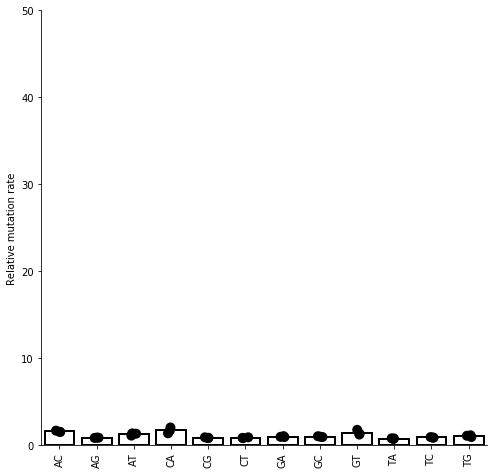

In [64]:
f, ax = plt.subplots()
sbn.barplot(x="mut", y="value", data=unmod, ci=None, order=sorted(set(unmod["mut"])), facecolor=(1, 1, 1, 0), linewidth=2,edgecolor="black")
sbn.stripplot(x="mut", y="value", data=unmod, color="black", order=sorted(set(unmod["mut"])), size=10, jitter=1)
ax.set_ylim(0, 50)
ax.set(xlabel="", ylabel="Relative mutation rate")
plt.xticks(*plt.xticks(), rotation=90)
sbn.despine()
f.set_size_inches(8, 8)
plt.show()

In [65]:
resultDir = "/groups/gerlich/experiments/Experiments_004700/004765/Results/"
f.savefig(os.path.join(resultDir, "Unmod_wScatter_woEdge.png"))
f.savefig(os.path.join(resultDir, "Unmod_wScatter_woEdge.pdf"))

# Plot modified samples with individual datapoints overlaid

In [19]:
mod = plotFrame.loc[plotFrame["condition"] == "OsO4 modified", :]

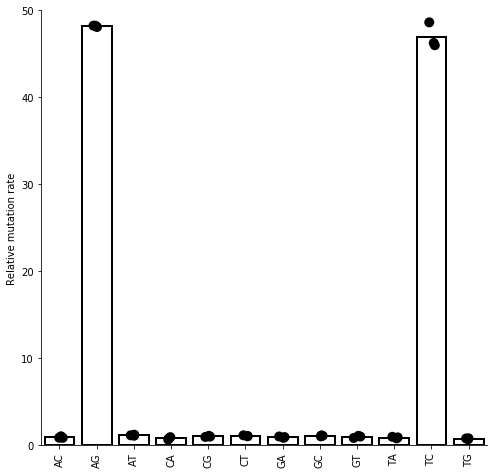

In [62]:
f, ax = plt.subplots()
sbn.barplot(x="mut", y="value", data=mod, ci=None, order=sorted(set(mod["mut"])), facecolor=(1, 1, 1, 0), linewidth=2,edgecolor="black")
sbn.stripplot(x="mut", y="value", data=mod, color="black", order=sorted(set(mod["mut"])), size=10, jitter=1)
ax.set_ylim(0, 50)
ax.set(xlabel="", ylabel="Relative mutation rate")
plt.xticks(*plt.xticks(), rotation=90)
sbn.despine()
f.set_size_inches(8, 8)
plt.show()

In [63]:
resultDir = "/groups/gerlich/experiments/Experiments_004700/004765/Results/"
f.savefig(os.path.join(resultDir, "Mod_wScatter_woEdge.png") ,dpi=300)
f.savefig(os.path.join(resultDir, "Mod_wScatter_woEdge.pdf"))

# Plot sequencing based mutation rate

## Load three control replicates

In [4]:
# set Directory
os.chdir("/groups/gerlich/experiments/Experiments_004500/"
         "004561/Sequencing_data/000000000-D_demultiplexed/hg19_SNPs")

# parse directory

files = parseDirectory("./")

# map barcodes

mapped = mapBarcodes(
    files, "/groups/gerlich/experiments/Experiments_004500/004557/Sample_mapping_exp4557.csv")

# open files and count mutations

mutationStatsControl = {}

for barcode, fileP in mapped.items():
    mutationStatsControl[barcode] = {}
    with pysam.AlignmentFile(fileP, "rb") as samfile:
        mutationStatsControl[barcode] = countMutations(samfile, reads=50000, mappingq=38,
                                                readqual=30, posQual=30)


0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
40000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
0 reads processed
10000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
40000 reads processed
50000 reads processed
0 reads processed
10000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed


In [5]:
HiCNorm = pd.DataFrame(mutationStats).T.reset_index().rename(columns={"index": "condition"})
control = pd.DataFrame(mutationStatsControl).T.reset_index().rename(columns={"index": "condition"})
molten4sT = pd.melt(HiCNorm, id_vars="condition")
moltenCont = pd.melt(control, id_vars="condition")

In [6]:
molten4sT.columns = ["condition", "mut", "value"]
moltenCont.columns = ["condition", "mut", "value"]

In [7]:
molten4sT.loc[:, "Condition"] = [i.split(" ")[0] + " " + i.split(" ")[1]
                                 for i in molten4sT.condition]

In [8]:
moltenCont.loc[:, "Condition"] = [i.split(" ")[0]
                                     for i in moltenCont.condition]

In [9]:
Cont = moltenCont.loc[moltenCont["Condition"] == "Control", :]
Cont.columns = ["Cont_" + i for i in Cont.columns]

fourTT = molten4sT.loc[molten4sT["Condition"] == "4sT new", :]
fourTT.columns = ["fourTT_" + i for i in fourTT.columns]


In [10]:
labelled = fourTT.groupby("fourTT_condition").apply(lambda x: x.loc[x["fourTT_mut"] == "AG", "fourTT_value"].values[0] + x.loc[x["fourTT_mut"] == "TC", "fourTT_value"].values[0]).reset_index()
labelled.iloc[:, 0] = "4sT"
labelled.columns = ["Name", "value"]
labelled

,Name,value
0,4sT,0.025083
1,4sT,0.024439
2,4sT,0.024504


In [11]:
unlabelled = Cont.groupby("Cont_condition").apply(lambda x: x.loc[x["Cont_mut"] == "AG", "Cont_value"].values[0] + x.loc[x["Cont_mut"] == "TC", "Cont_value"].values[0]).reset_index()
unlabelled.iloc[:, 0] = "Control"
unlabelled.columns = ["Name", "value"]
unlabelled

,Name,value
0,Control,0.000908
1,Control,0.000918
2,Control,0.000909


In [12]:
plotFrame = pd.concat((labelled, unlabelled))
plotFrame.loc[:, "perc"] = plotFrame["value"] * 100

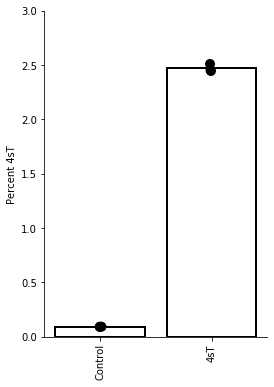

In [18]:
f, ax = plt.subplots()
sbn.barplot(x="Name", y="perc", data=plotFrame, ax=ax, color="black",facecolor=(1, 1, 1, 0) , linewidth=2,edgecolor="black", ci=None, order=["Control", "4sT"])
sbn.stripplot(x="Name", y="perc", data=plotFrame, color="black", size=10, jitter=0.02, ax=ax, order=["Control", "4sT"])
ax.set_xlabel("")
ax.set_ylabel("Percent 4sT")
sbn.despine()
plt.xticks(*plt.xticks(), rotation=90)
sbn.despine()
ax.set_ylim(0, 3)
f.set_size_inches(4, 6)
plt.show()

In [19]:
resultDir = "/groups/gerlich/experiments/Experiments_004700/004765/Results"
f.savefig(os.path.join(resultDir, "4sT_percentage_exp4594_black_wPoints.png"), bbox_inches="tight")
f.savefig(os.path.join(resultDir, "4sT_percentage_exp4594_black_wPoints.pdf"), bbox_inches="tight")
